In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
import warnings
warnings.filterwarnings('ignore')
import os
import pandas as pd
import numpy as np
import math
import datetime as dt
import matplotlib.pyplot as plt

from sklearn.metrics import mean_squared_error, mean_absolute_error, explained_variance_score, r2_score
from sklearn.metrics import mean_poisson_deviance, mean_gamma_deviance, accuracy_score
from sklearn.preprocessing import MinMaxScaler

from itertools import product
import statsmodels.api as sm
import tensorflow as tf

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.layers import LSTM

from itertools import cycle
import plotly.offline as py
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots
plt.style.use('seaborn-darkgrid')

In [4]:
#importing dataset ad transforming time series dataset into samples, where each sample has an input component X and an output component Y. this model will learn how to map input to output from provided examples.

root_path = '/content/drive/MyDrive/Colab Notebooks/btc_ohlc_Oct_2015_to_Oct_2021.csv'
btc_input_df=pd.read_csv(root_path)
btc_input_df.tail()

,time,low,high,open,close,volume
3113271,2015-10-27 00:04:00,287.07,287.07,287.07,287.07,0.08610
3113272,2015-10-27 00:03:00,287.08,287.09,287.08,287.09,0.55440
3113273,2015-10-27 00:02:00,286.89,287.10,287.10,286.89,72.40320
3113274,2015-10-27 00:01:00,287.09,287.09,287.09,287.09,0.82276
3113275,2015-10-27 00:00:00,287.10,287.10,287.10,287.10,0.53620


In [5]:
btc_input_df.shape

(3113276, 6)

In [6]:
btc_input_df.describe()

,low,high,open,close,volume
count,3.113276e+06,3.113276e+06,3.113276e+06,3.113276e+06,3.113276e+06
mean,1.152825e+04,1.154230e+04,1.153537e+04,1.153541e+04,9.689568e+00
std,1.490292e+04,1.492446e+04,1.491374e+04,1.491379e+04,2.239875e+01
min,6.000000e-02,6.000000e-02,6.000000e-02,6.000000e-02,1.000000e-08
25%,1.849557e+03,1.850000e+03,1.849925e+03,1.849980e+03,1.331197e+00
50%,7.099990e+03,7.105000e+03,7.102045e+03,7.102060e+03,3.707298e+00
75%,1.067558e+04,1.068550e+04,1.068027e+04,1.068040e+04,9.761575e+00
max,6.690000e+04,6.699900e+04,6.694122e+04,6.694122e+04,1.549613e+03


In [7]:
btc_input_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3113276 entries, 0 to 3113275
Data columns (total 6 columns):
 #   Column  Dtype  
---  ------  -----  
 0   time    object 
 1   low     float64
 2   high    float64
 3   open    float64
 4   close   float64
 5   volume  float64
dtypes: float64(5), object(1)
memory usage: 142.5+ MB


convet 'time' column from object dtye to datetime dtype

In [10]:
btc_input_df_datetype = btc_input_df.astype({'time': 'datetime64'})

In [11]:
btc_input_df_datetype.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3113276 entries, 0 to 3113275
Data columns (total 6 columns):
 #   Column  Dtype         
---  ------  -----         
 0   time    datetime64[ns]
 1   low     float64       
 2   high    float64       
 3   open    float64       
 4   close   float64       
 5   volume  float64       
dtypes: datetime64[ns](1), float64(5)
memory usage: 142.5 MB


In [12]:
print('Null values:', btc_input_df_datetype.isnull().values.sum())

Null values: 0


<AxesSubplot:title={'center':'Bitcoin Weighted Price'}, xlabel='time'>

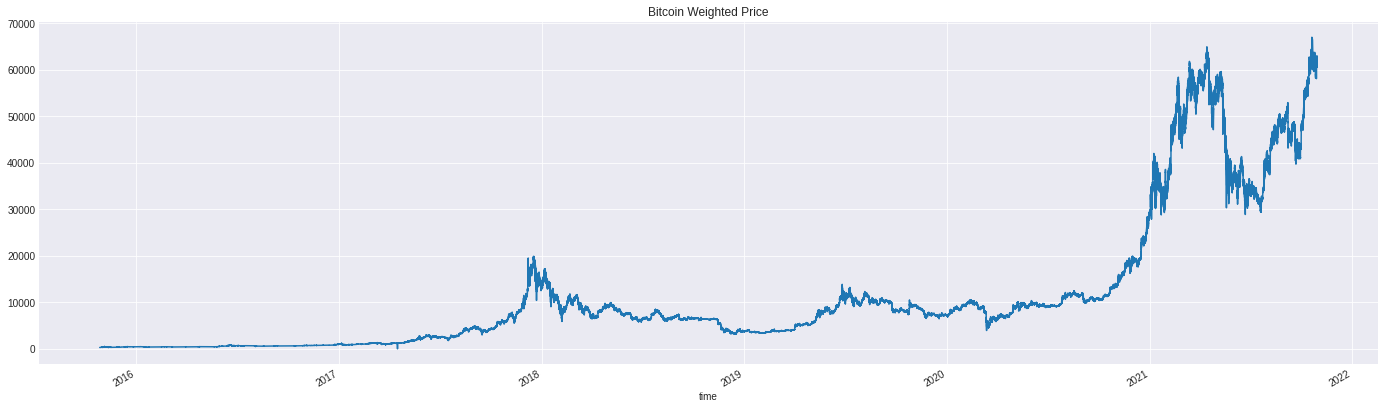

In [13]:
btc_input_df_datetype.set_index("time").close.plot(figsize=(24,7),title="Bitcoin Weighted Price")

plotting lag plot to observe autocorrelation. these are crucial when when we try to correct the trend and stationary and we have to use smoothing functions.

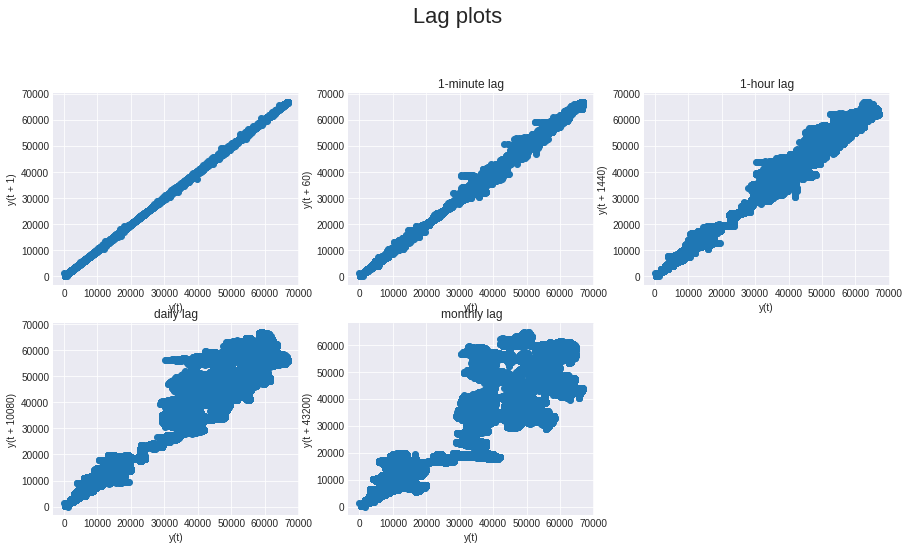

In [17]:
plt.figure(figsize=(15,12))
plt.suptitle('Lag plots', fontsize=22)
plt.subplot(3,3,1)
pd.plotting.lag_plot(btc_input_df_datetype['close'], lag=1) # minute lag
plt.subplot(3,3,2)
plt.title('1-minute lag')
pd.plotting.lag_plot(btc_input_df_datetype['close'], lag=60) # hour lag
plt.subplot(3,3,3)
plt.title('1-hour lag')
pd.plotting.lag_plot(btc_input_df_datetype['close'], lag=1440) # daily lag
plt.subplot(3,3,4)
plt.title('daily lag')
pd.plotting.lag_plot(btc_input_df_datetype['close'], lag=10080) # weekly lag
plt.subplot(3,3,5)
plt.title('weekly lag')
pd.plotting.lag_plot(btc_input_df_datetype['close'], lag=43200) # month lag
plt.title('monthly lag')

plt.legend()
plt.show()

making data ready for LSTM-
pd.to_datetime(unit='s') and then groupby('date')

In [19]:
btc_input_df_datetype['date']=pd.to_datetime(btc_input_df_datetype['time'],unit='s').dt.date
display(btc_input_df_datetype.head())
group = btc_input_df_datetype.groupby('date')
btc_closing_price_groupby_date = group['close'].mean()

,time,low,high,open,close,volume,date
0,2021-10-30 03:00:00,61868.81,61920.00,61888.18,61919.98,2.946079,2021-10-30
1,2021-10-30 02:59:00,61882.74,61912.67,61903.16,61882.74,2.942357,2021-10-30
2,2021-10-30 02:58:00,61854.82,61907.96,61854.82,61903.15,3.047848,2021-10-30
3,2021-10-30 02:57:00,61848.04,61883.02,61883.01,61851.39,3.381070,2021-10-30
4,2021-10-30 02:56:00,61879.33,61925.42,61907.47,61882.28,5.663128,2021-10-30


In [20]:
display(btc_closing_price_groupby_date.head(10))
print("legth of btc_closing_price_groupby_date:", len(btc_closing_price_groupby_date))

date
2015-10-27    292.887484
2015-10-28    301.991834
2015-10-29    310.537530
2015-10-30    326.665808
2015-10-31    323.877132
2015-11-01    319.527295
2015-11-02    339.226860
2015-11-03    386.773759
2015-11-04    450.035105
2015-11-05    400.249521
Name: close, dtype: float64

legth of btc_closing_price_groupby_date: 2196


train test split

In [26]:
prediction_days = 60
df_train = btc_closing_price_groupby_date[:len(btc_closing_price_groupby_date)-prediction_days].values.reshape(-1,1)
df_test = btc_closing_price_groupby_date[len(btc_closing_price_groupby_date)-prediction_days:].values.reshape(-1,1)


In [27]:
df_test.shape

(60, 1)

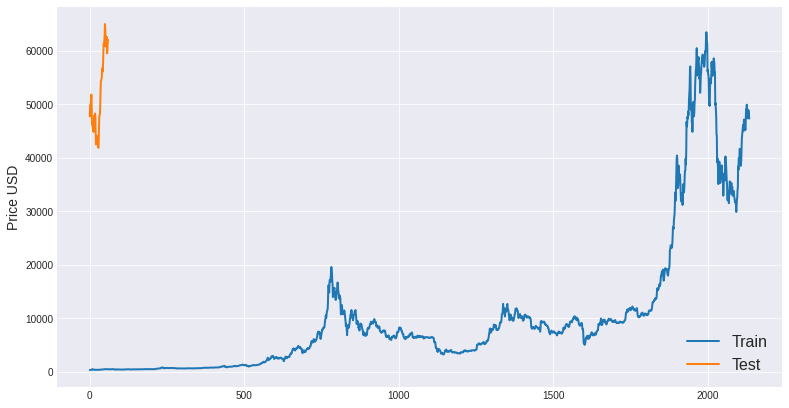

In [30]:
chosen_col = 'Close'
fig, ax = plt.subplots(1,figsize=(13,7))
ax.plot(df_train,label='Train', linewidth=2)
ax.plot(df_test, label='Test', linewidth=2)
ax.set_ylabel('Price USD', fontsize=14)
ax.set_title('',fontsize=16)
ax.legend(loc='best',fontsize=16)

min max scaling of train test data

In [32]:
scaler_train = MinMaxScaler(feature_range=(0,1))
scaler_train = scaler_train.fit_transform(df_train)

scaler_test = MinMaxScaler(feature_range=(0,1))
scaler_test = scaler_test.fit_transform(df_test)

dataset generator function for LSTM to take samples of previous data to predict next output

In [34]:
def dataset_generator_lstm(dataset, look_back=5):
  dataX, dataY = [], []

  for i in range(len(dataset)- look_back):
    window_size_x= dataset[i:(i + look_back),0]
    dataX.append(window_size_x)
    dataY.append(dataset[ i + look_back, 0])
  return np.array(dataX),np.array(dataY) 

trainX, trainY = dataset_generator_lstm(scaler_train)
testX, testY = dataset_generator_lstm(scaler_test)
print("trainX:", trainX.shape) 
print("trainY:", trainY.shape)   
print("testX:", testX.shape)
print("testY:", testY.shape)


trainX: (2131, 5)
trainY: (2131,)
testX: (55, 5)
testY: (55,)
